# Time Series Forecasting 
## ARIMA Model - USD/CNY Spot Rate  

Time series forecasting of US Dollar to Chinese Yuan Renminbi spot exchange rate with ARIMA model. 
A foreign exchange spot transaction, also known as FX spot, is an agreement between two parties to buy one currency against selling another currency at an agreed price for settlement on the spot date. [[Wikipedia]](https://en.wikipedia.org/wiki/Foreign_exchange_spot). The exchange rate at which the transaction is done is called the spot exchange rate. 
ARIMA models are applied in some cases where data show evidence of non-stationarity in the sense of mean, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity of the mean function (i.e., the trend) [[Wikipedia]](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) 

---

Data source: Board of Governors of the Federal Reserve System (US), Chinese Yuan Renminbi to U.S. Dollar Spot Exchange Rate [DEXCHUS], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DEXCHUS <br>

Frequency: Daily <br>
Date range: 2020/02/25 - 2022/02/25 <br>
Units: Chinese Yuan Renminbi to One U.S. Dollar <br>

---
NOTE: to be sure that both python inputs and outputs are correctly rendered, notebook must be visualised with nbviewer. 
[![nbviewer](https://img.shields.io/badge/view%20in-nbviewer-orange)]https://nbviewer.org/github/lorenzogalata/Time-Series-Analysis/blob/main/Forecasting/1.%20ARIMA%20-%20USDCNY%20Spot%20Rate.ipynb) 
🏷️: <em> stationarity, ARIMA, residual diagnostic, forecasting </em>

#### Packages, modules, options and functions

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Packages & modules
from arch.unitroot import PhillipsPerron
from numpy import diff, transpose
from matplotlib.dates import DateFormatter
from pandas import read_csv, Series
from pmdarima.arima import auto_arima
from scipy.stats import kstest
from seaborn import boxplot, histplot, kdeplot, lineplot   
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error  
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_white
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import adfuller, kpss

# Functions
def mean_absolute_scaled_error(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = abs(diff( training_series)).sum()/(n-1)
    errors = abs(testing_series - prediction_series)
    return errors.mean()/d

# Plot parameters
from matplotlib import pyplot, pylab
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
params = {'figure.titlesize':'medium', 'axes.titlesize':'medium',
          'legend.fontsize': 'x-small', 'legend.title_fontsize': 'x-small',
          'axes.labelsize': 'x-small', 
          'xtick.labelsize':'xx-small', 'ytick.labelsize':'xx-small',
          'figure.dpi':150}
pylab.rcParams.update(params)

### 1. Data preparation

In [2]:
data = read_csv('USDCNY_2022-02-25.csv', parse_dates=['DATE'], index_col=['DATE'])
data.columns = ['rate']
data.index.names = ['date']

data.rate = data.loc[data.rate != '.']
data.dropna(inplace=True)
data.rate = data.rate.astype(float)

print(data.head(5))

              rate
date              
2020-02-25  7.0128
2020-02-26  7.0214
2020-02-27  7.0036
2020-02-28  6.9906
2020-03-02  6.9595


Split the data into train and test sets.

In [3]:
train = data.head(int(len(data)*0.9)).copy()
test = data.tail(int(len(data)*0.1)).copy()

### 2. Data visualization

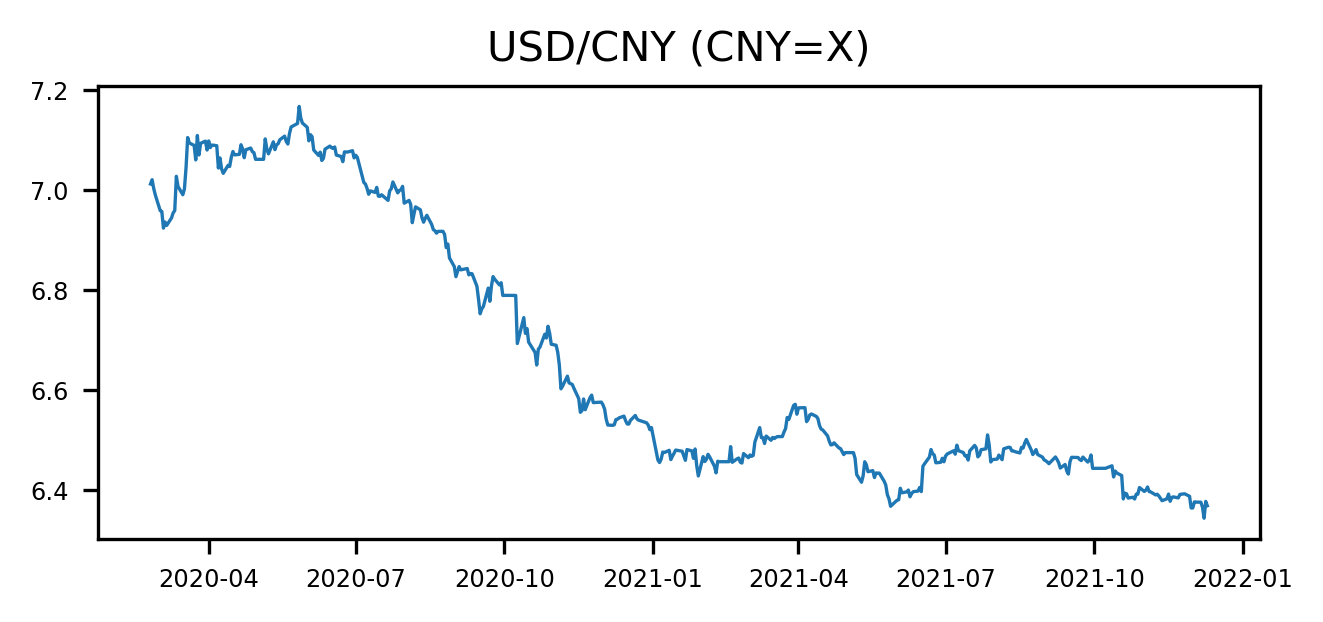

In [4]:
fig, ax = pyplot.subplots(figsize=(5,2))
lineplot(data=train.rate, linewidth=.8)

ax.set_title('USD/CNY (CNY=X)')
ax.set_ylabel(None)
ax.set_xlabel(None)

pyplot.show()

### 3. Data pre-processing

Time series shows a decreasing stochastic trend that results in a systematic change of the mean and does not look stationary. <br> 
Test for stationarity with ADF and KPSS test.  

In [5]:
import warnings
warnings.filterwarnings("ignore")

print('ADF statistic: %f' % adfuller(train.rate)[0])
print('p-value: %f' % adfuller(train.rate)[1])
print('KPSS statistic: %f' % kpss(train.rate)[0])
print('p-value: %f' % kpss(train.rate)[1])

ADF statistic: -0.827128
p-value: 0.811023
KPSS statistic: 3.121367
p-value: 0.010000


p-value of ADF test is larger than 0.05 so the null hypothesis of unit root cannot be rejected. <br>
p-value of KPSS test is less than 0.05 so the null hypothesis of trend-stationarity is rejected. <br>
The series is neither stationary nor trend-stationary.

Remove the trend by taking the first order difference of the series.

In [6]:
train['difference'] = train.rate.diff(1)
train.dropna(inplace=True)

print('ADF statistic: %f' % adfuller(train.difference)[0])
print('p-value: %f' % adfuller(train.difference)[1])
print('PP statistic: %.4f' % PhillipsPerron(train.difference).stat)
print('p-value: %.4f' % PhillipsPerron(train.difference).pvalue)

ADF statistic: -24.505214
p-value: 0.000000
PP statistic: -24.5566
p-value: 0.0000


p-value of ADF test is less than 0.05 so the null hypothesis of unit root is rejected. <br>
p-value of PP test is less than 0.05 so the null hypothesis of unit root is rejected. <br>
Both tests conclude that the series is stationary.

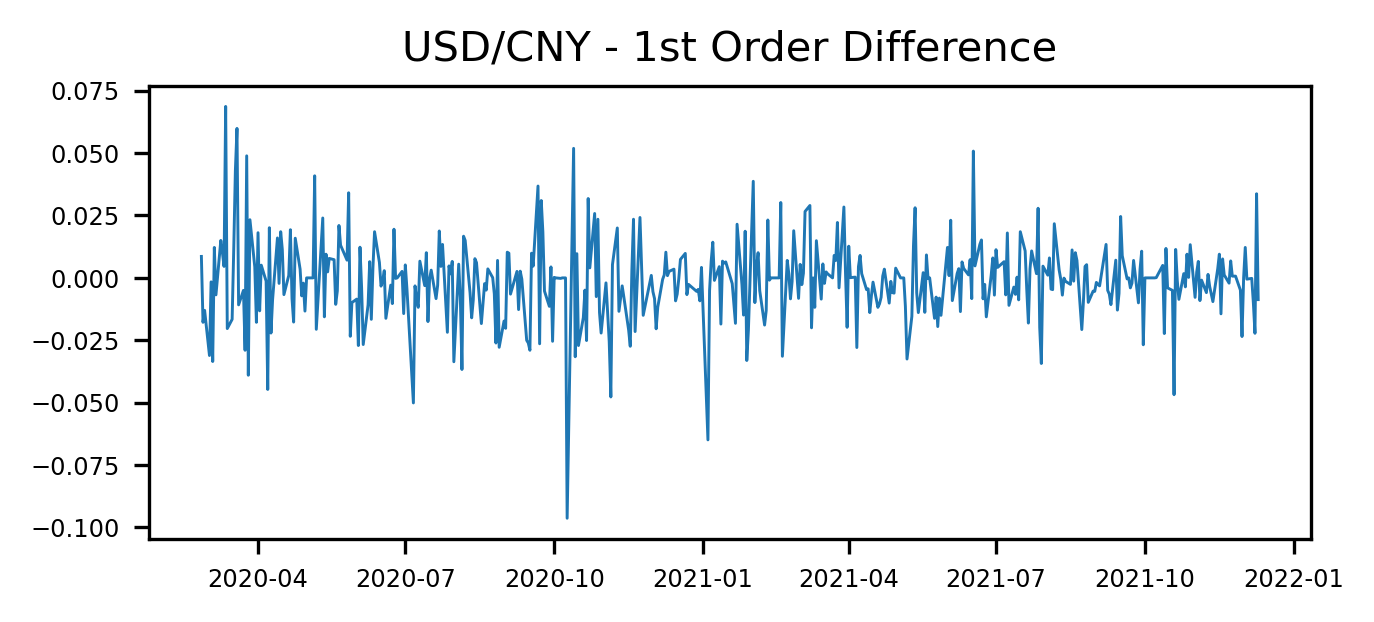

In [7]:
fig, ax = pyplot.subplots(figsize=(5,2))
lineplot(data=train.difference, linewidth=.7)

ax.set_title('USD/CNY - 1st Order Difference')
ax.set_ylabel(None)
ax.set_xlabel(None)

pyplot.show()

### 4. Model fitting

Fit ARIMA model.

In [8]:
arima = auto_arima(train.rate, d=1)
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  449
Model:               SARIMAX(1, 1, 0)   Log Likelihood                1212.184
Date:                Thu, 24 Mar 2022   AIC                          -2418.367
Time:                        20:37:04   BIC                          -2406.053
Sample:                             0   HQIC                         -2413.513
                                - 449                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0017      0.001     -2.171      0.030      -0.003      -0.000
ar.L1         -0.1462      0.038     -3.896      0.000      -0.220      -0.073
sigma2         0.0003    9.8e-06     26.661      0.0

Plot observed and fitted values.

In [9]:
fitted = Series(arima.predict_in_sample())[1:]
fitted.index = train.index[1:]

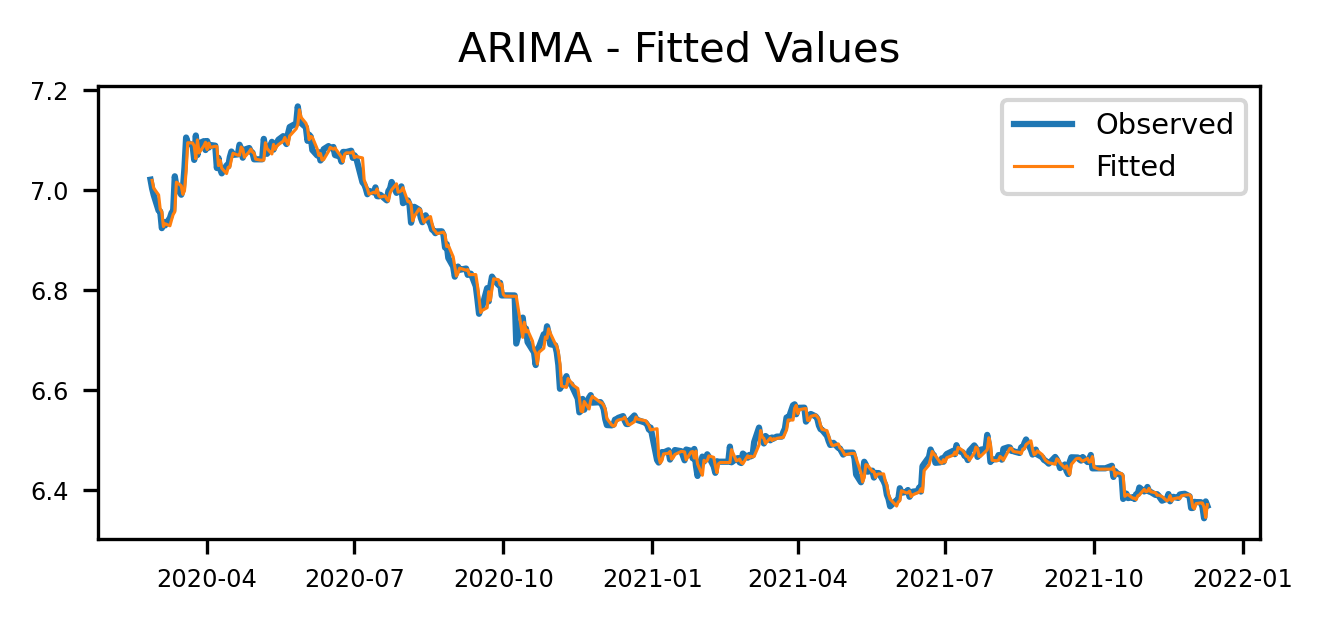

In [10]:
fig, ax = pyplot.subplots(figsize=(5,2))

lineplot(data=train.rate,  label='Observed')
lineplot(data=fitted, linewidth=.75, label='Fitted')

ax.set_title('ARIMA - Fitted Values')
ax.legend(loc='upper right')
ax.set_ylabel(None)
ax.set_xlabel(None)

pyplot.show()

### 5. Model diagnostics

In [11]:
arima_resid = Series(arima.resid()).iloc[1:]

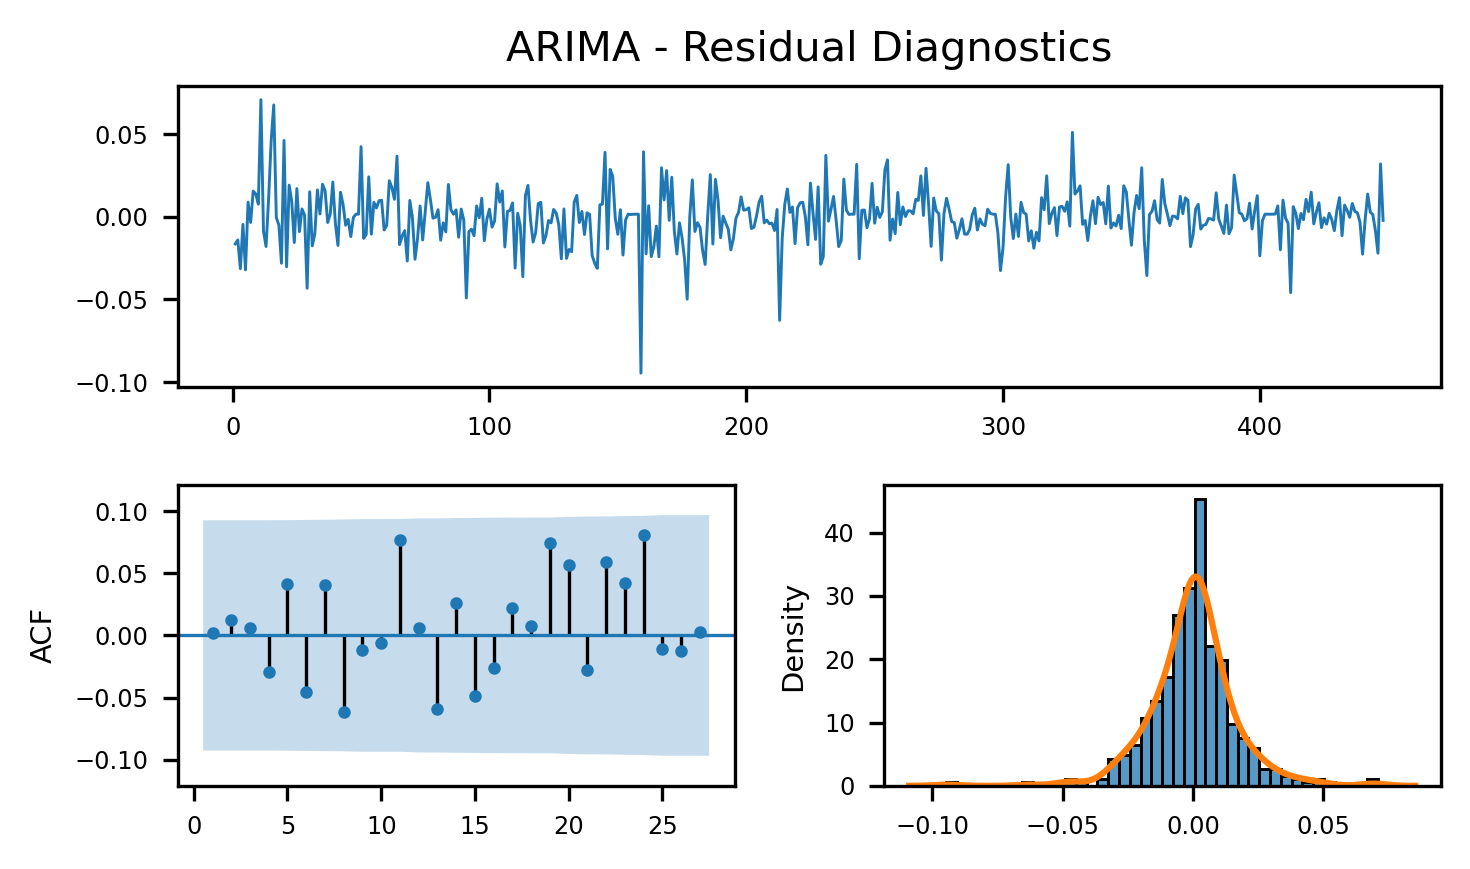

In [12]:
fig, axs = pyplot.subplot_mosaic([['line', 'line'],
                                   ['acf', 'hist']],
                                  figsize=(5, 3))

lineplot(ax=axs['line'], data=arima_resid, linewidth=.7)
axs['line'].set_title('ARIMA - Residual Diagnostics')

plot_acf(ax=axs['acf'], x=arima_resid, 
         zero=False, auto_ylims=True, title=None,
         markersize=2, linewidth=.8, vlines_kwargs={'color':'black', 'linewidth':.8})
axs['acf'].set_ylabel('ACF')

histplot(ax=axs['hist'], data=arima_resid, stat='density' ,linewidth=.7)
kdeplot(ax=axs['hist'], data=arima_resid, color='tab:orange')
axs['hist'].set_ylabel('Density')

fig.align_labels()
pyplot.tight_layout()

pyplot.show()

In [13]:
print(acorr_ljungbox(arima_resid))

     lb_stat  lb_pvalue
1   0.001131   0.973172
2   0.071001   0.965122
3   0.085530   0.993515
4   0.483416   0.975095
5   1.262311   0.938762
6   2.203896   0.900024
7   2.944383   0.890099
8   4.678404   0.791330
9   4.738059   0.856518
10  4.755189   0.906920


ACF plot shows little to none autocorrelation. <br>
p-values of Ljung-Box test for autocorrelation are larger than 0.05 so the null hypothesis of independent distribution cannot be rejected. <br>
Both checks conclude that the residuals do not exhibit serial correlation.

In [14]:
f'{arima_resid.mean():.7f}'

'0.0000012'

The mean of the residuals is very close to zero so the forecasts are unbiased.

### 6. Forecasting

Plot observed values, predicted values and confidence interval.

In [15]:
test = data.tail(int(len(data)*0.1)).copy()

fcast, confint = Series(arima.predict(n_periods=len(test), return_conf_int=True))

test['forecast'] = fcast
test['lower'] = confint[:,0]
test['upper'] = confint[:,1]

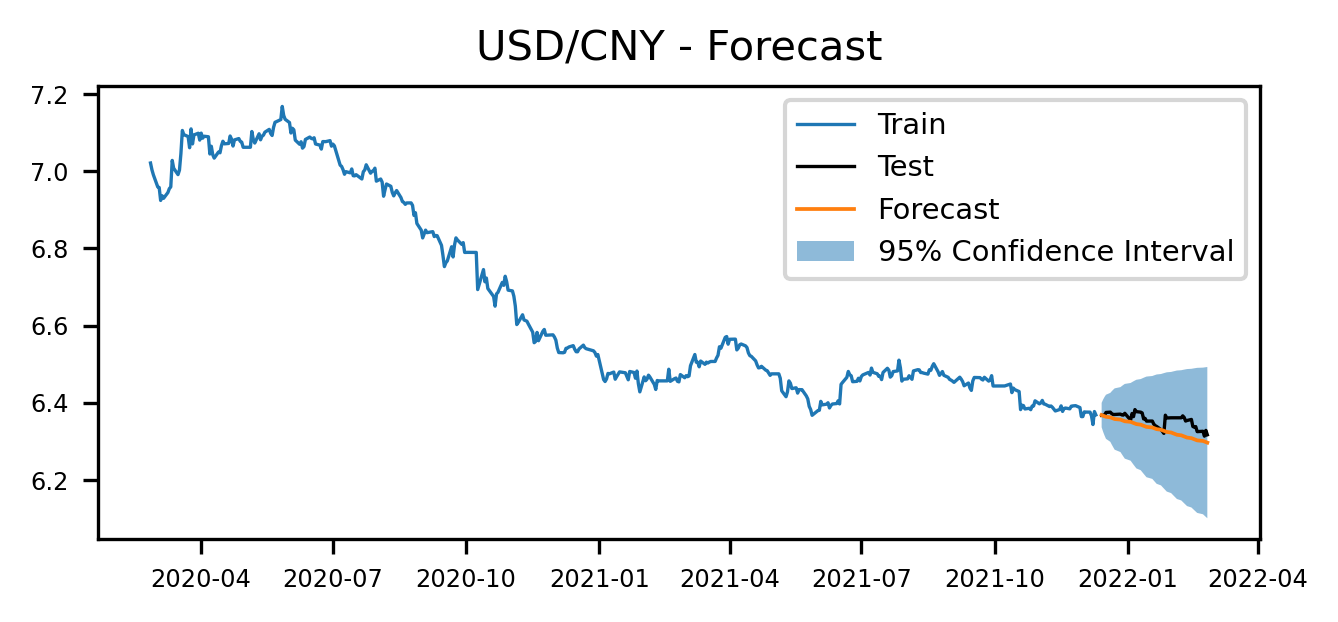

In [16]:
fig, ax = pyplot.subplots(figsize=(5,2))

lineplot(data=train.rate, linewidth=.8, color='tab:blue', label='Train')
lineplot(data=test.rate, linewidth=.8, color='black', label='Test')
lineplot(data=test.forecast, linewidth=.9, color='tab:orange', label='Forecast')
ax.fill_between(x=test.index, y1=test.lower, y2=test.upper, 
                alpha=.5, label='95% Confidence Interval')

ax.set_title('USD/CNY - Forecast')
ax.legend(loc='upper right')
ax.set_ylabel(None)
ax.set_xlabel(None)

pyplot.show()

In [17]:
print('RMSE:', round(mean_squared_error(test.rate, test.forecast, squared=False), 4))        
print('MAE:', round(mean_absolute_error(test.rate, test.forecast), 4)) 
print('MAPE:', round(mean_absolute_percentage_error(test.rate, test.forecast), 4))
print('MASE:', round(mean_absolute_scaled_error(train.rate, test.rate, test.forecast), 4))

RMSE: 0.0279
MAE: 0.0236
MAPE: 0.0037
MASE: 2.0679


MAPE = 0.0037 means that, on average, the forecast is off by 0.37%